<a href="https://colab.research.google.com/github/tspn/Covid19Forecasting/blob/main/Uptrend_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==0.24

In [ ]:
IntervalDays = 5
MovingAverageWindow = IntervalDays
PredictionTargetDay = 1
CumulativeCases = "Cumulative_cases"
NewCases = "New_cases"
NormalizedCumulativeCases = "Normalized_cumulative_cases"
NormalizedNewCases = "Normalized_new_cases"
NormalizedMovingAvgCumulativeCases = "Normalized_MA_cumulative_cases"
NormalizedMovingAvgNewCases = "Normalized_MA_new_cases"

PredictionTargetDay = PredictionTargetDay - 1 

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MAPE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from statistics import mean
plt.rcParams['figure.figsize'] = [32, 12]

In [ ]:
df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', skipinitialspace=True)
df.set_index('Date_reported', inplace=True)
df = df[df["Country"].isin(df[df["Cumulative_cases"] > 10000]["Country"].unique())]
df = df[df["Country"].isin(df[df["New_cases"] > 400]["Country"].unique())]
df = df[~df["Country"].isin(df[df["New_cases"] < 0]["Country"].unique())]
# df = df.drop(["2021-01-20", "2021-01-21", "2021-01-22", "2021-01-23", "2021-01-24", "2021-01-25", "2021-01-26", "2021-01-27"])
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0
2020-01-04,AL,Albania,EURO,0,0,0,0
2020-01-05,AL,Albania,EURO,0,0,0,0
2020-01-06,AL,Albania,EURO,0,0,0,0
2020-01-07,AL,Albania,EURO,0,0,0,0
...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254


In [ ]:
cumulativeScaler = StandardScaler()
cumulativeScaler.fit(df[CumulativeCases].values.reshape(-1, 1))
df[NormalizedCumulativeCases] = cumulativeScaler.transform(df[CumulativeCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases
Date_reported,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204650
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204650
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204650
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204650
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204650
...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.176035
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175898
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175670


In [ ]:
newCasesScaler = StandardScaler()
newCasesScaler.fit(df[NewCases].values.reshape(-1, 1))
df[NormalizedNewCases] = cumulativeScaler.transform(df[NewCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases
Date_reported,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650
...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.176035,-0.204550
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175898,-0.204513
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175670,-0.204422


In [ ]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgCumulativeCases]] = df[df["Country"] == country][NormalizedCumulativeCases].rolling(10).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases
Date_reported,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.176035,-0.204550,-0.177134
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175898,-0.204513,-0.176875
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175670,-0.204422,-0.176634


In [ ]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgNewCases]] = df[df["Country"] == country][NormalizedNewCases].rolling(10).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.176035,-0.204550,-0.177134,-0.204364
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175898,-0.204513,-0.176875,-0.204391
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175670,-0.204422,-0.176634,-0.204410


In [ ]:
df = df.dropna()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-12,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,-0.204650,-0.204650
2020-01-13,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,-0.204650,-0.204650
2020-01-14,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,-0.204650,-0.204650
2020-01-15,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,-0.204650,-0.204650
2020-01-16,AL,Albania,EURO,0,0,0,0,-0.204650,-0.204650,-0.204650,-0.204650
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.176035,-0.204550,-0.177134,-0.204364
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175898,-0.204513,-0.176875,-0.204391
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175670,-0.204422,-0.176634,-0.204410


In [ ]:
test_country = ["Brazil", "Thailand", "Malaysia", "Japan", "Republic of Korea"]
train_country = ['Albania','Algeria','Argentina','Armenia','Australia','Austria',
 'Azerbaijan','Bahrain','Bangladesh','Belarus','Belgium','Belize',
 'Bosnia and Herzegovina','Botswana','Bulgaria','Cabo Verde','Cameroon',
 'Canada','Chile','China','Colombia','Costa Rica','Côte d’Ivoire',
 'Croatia','Cyprus','Czechia','Democratic Republic of the Congo','Denmark',
 'Dominican Republic','Egypt','El Salvador','Estonia','Finland',
 'French Polynesia','Georgia','Germany','Ghana','Greece','Hungary','India',
 'Indonesia','Iran (Islamic Republic of)','Iraq','Ireland','Israel',
 'Jordan','Kazakhstan','Kenya','Kosovo[1]','Kuwait','Kyrgyzstan','Latvia',
 'Lebanon','Libya','Lithuania','Mexico','Montenegro','Morocco',
 'Mozambique','Myanmar','Netherlands','Nigeria','North Macedonia','Norway',
 'Oman','Pakistan','Panama','Peru','Philippines','Poland','Qatar',
 'Republic of Moldova','Romania','Russian Federation','Saudi Arabia',
 'Serbia','Singapore','Slovakia','Slovenia','South Africa','Spain',
 'Sri Lanka','Sweden','Switzerland','Tajikistan','The United Kingdom',
 'Tunisia','Turkey','Ukraine','United Arab Emirates',
 'United States of America','Uruguay','Uzbekistan',
 'Venezuela (Bolivarian Republic of)','Zimbabwe']

In [ ]:
def isUptrend(country, i):
  v = df[df["Country"] == country][NormalizedMovingAvgNewCases].values
  return v[i] < mean(v[i:i+IntervalDays])

In [ ]:
X = []
Y = []
for country in train_country:
  v = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
  for i in range(0, len(v) - IntervalDays-PredictionTargetDay):
    if isUptrend(country, i):
      X.append(v[i:i+IntervalDays])
      Y.append(v[i+IntervalDays+PredictionTargetDay])
  print(country)
X = np.array(X).reshape(-1, IntervalDays, 1)
Y = np.array(Y)

Albania
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Belize
Bosnia and Herzegovina
Botswana
Bulgaria
Cabo Verde
Cameroon
Canada
Chile
China
Colombia
Costa Rica
Côte d’Ivoire
Croatia
Cyprus
Czechia
Democratic Republic of the Congo
Denmark
Dominican Republic
Egypt
El Salvador
Estonia
Finland
French Polynesia
Georgia
Germany
Ghana
Greece
Hungary
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Jordan
Kazakhstan
Kenya
Kosovo[1]
Kuwait
Kyrgyzstan
Latvia
Lebanon
Libya
Lithuania
Mexico
Montenegro
Morocco
Mozambique
Myanmar
Netherlands
Nigeria
North Macedonia
Norway
Oman
Pakistan
Panama
Peru
Philippines
Poland
Qatar
Republic of Moldova
Romania
Russian Federation
Saudi Arabia
Serbia
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Tajikistan
The United Kingdom
Tunisia
Turkey
Ukraine
United Arab Emirates
United States of America
Uruguay
Uzbekistan
Venezuela (Bolivarian Republic of)
Zimbabwe


In [ ]:
i = Input(shape=(IntervalDays, 1))
x = LSTM(IntervalDays)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=["mape"])

In [ ]:
r = model.fit(X, Y, epochs=100, verbose=2, validation_split=0.3)

Epoch 1/100
415/415 - 3s - loss: 0.1002 - mape: 248.5231 - val_loss: 1.7525 - val_mape: 17.1936
Epoch 2/100
415/415 - 1s - loss: 0.0571 - mape: 60.6047 - val_loss: 1.4836 - val_mape: 68.0875
Epoch 3/100
415/415 - 1s - loss: 0.0411 - mape: 107.8728 - val_loss: 1.1827 - val_mape: 62.7586
Epoch 4/100
415/415 - 1s - loss: 0.0262 - mape: 81.0649 - val_loss: 0.9802 - val_mape: 45.8965
Epoch 5/100
415/415 - 1s - loss: 0.0199 - mape: 72.1082 - val_loss: 0.8821 - val_mape: 33.6736
Epoch 6/100
415/415 - 1s - loss: 0.0161 - mape: 52.6672 - val_loss: 0.8068 - val_mape: 25.5826
Epoch 7/100
415/415 - 2s - loss: 0.0133 - mape: 43.9548 - val_loss: 0.7478 - val_mape: 21.0284
Epoch 8/100
415/415 - 1s - loss: 0.0109 - mape: 39.2748 - val_loss: 0.6906 - val_mape: 18.1035
Epoch 9/100
415/415 - 1s - loss: 0.0088 - mape: 37.3089 - val_loss: 0.6414 - val_mape: 15.5214
Epoch 10/100
415/415 - 1s - loss: 0.0071 - mape: 32.7345 - val_loss: 0.5996 - val_mape: 12.4986
Epoch 11/100
415/415 - 1s - loss: 0.0057 - mape

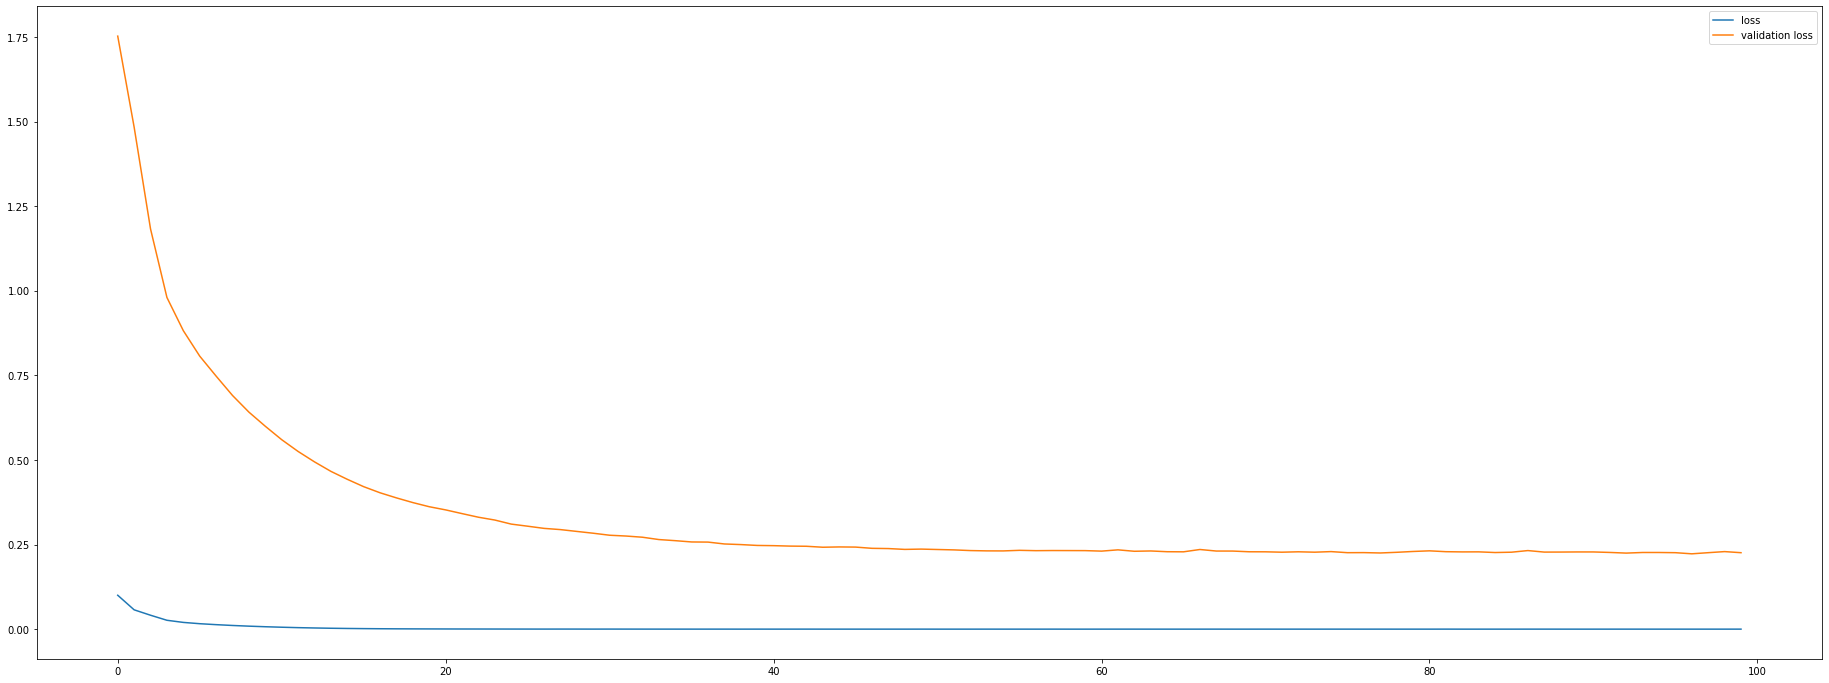

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

Brazil 2.2008046156553127
Thailand 1.504876538816401
Malaysia 1.4545931238062904
Japan 3.717902097534061
Republic of Korea 2.6231469747441243


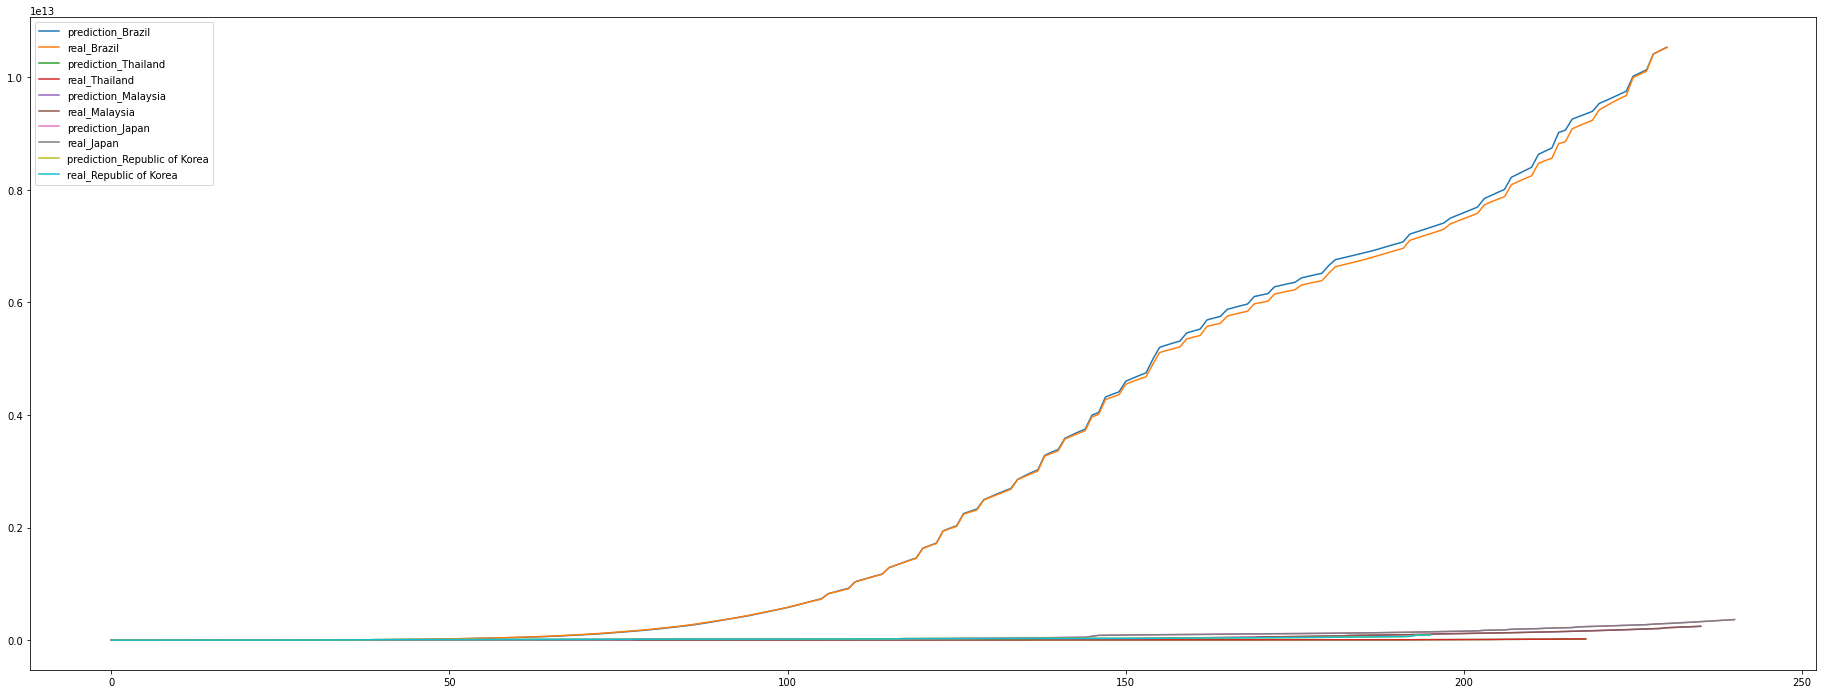

In [ ]:
def test(countryList, plot = False):
  for country in countryList:
    Xr = []
    Yr = []
    v = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
    for i in range(0, len(v) - IntervalDays - PredictionTargetDay):
      if isUptrend(country, i):
        Xr.append(v[i:i+IntervalDays])
        Yr.append(v[i+IntervalDays+PredictionTargetDay])
    Xr = np.array(Xr).reshape(-1, IntervalDays, 1)
    Yr = np.array(Yr)
    Yp = model.predict(Xr)
    Yr = cumulativeScaler.inverse_transform(Yr)
    Yp = cumulativeScaler.inverse_transform(Yp)
    print(country, mean_absolute_percentage_error(Yr, Yp))
    if plot:
      plt.plot(cumulativeScaler.inverse_transform(Yp), label='prediction_'+country)
      plt.plot(cumulativeScaler.inverse_transform(Yr), label='real_'+country)
      plt.legend()

test(test_country, True)

Brazil 2.2008046156553127


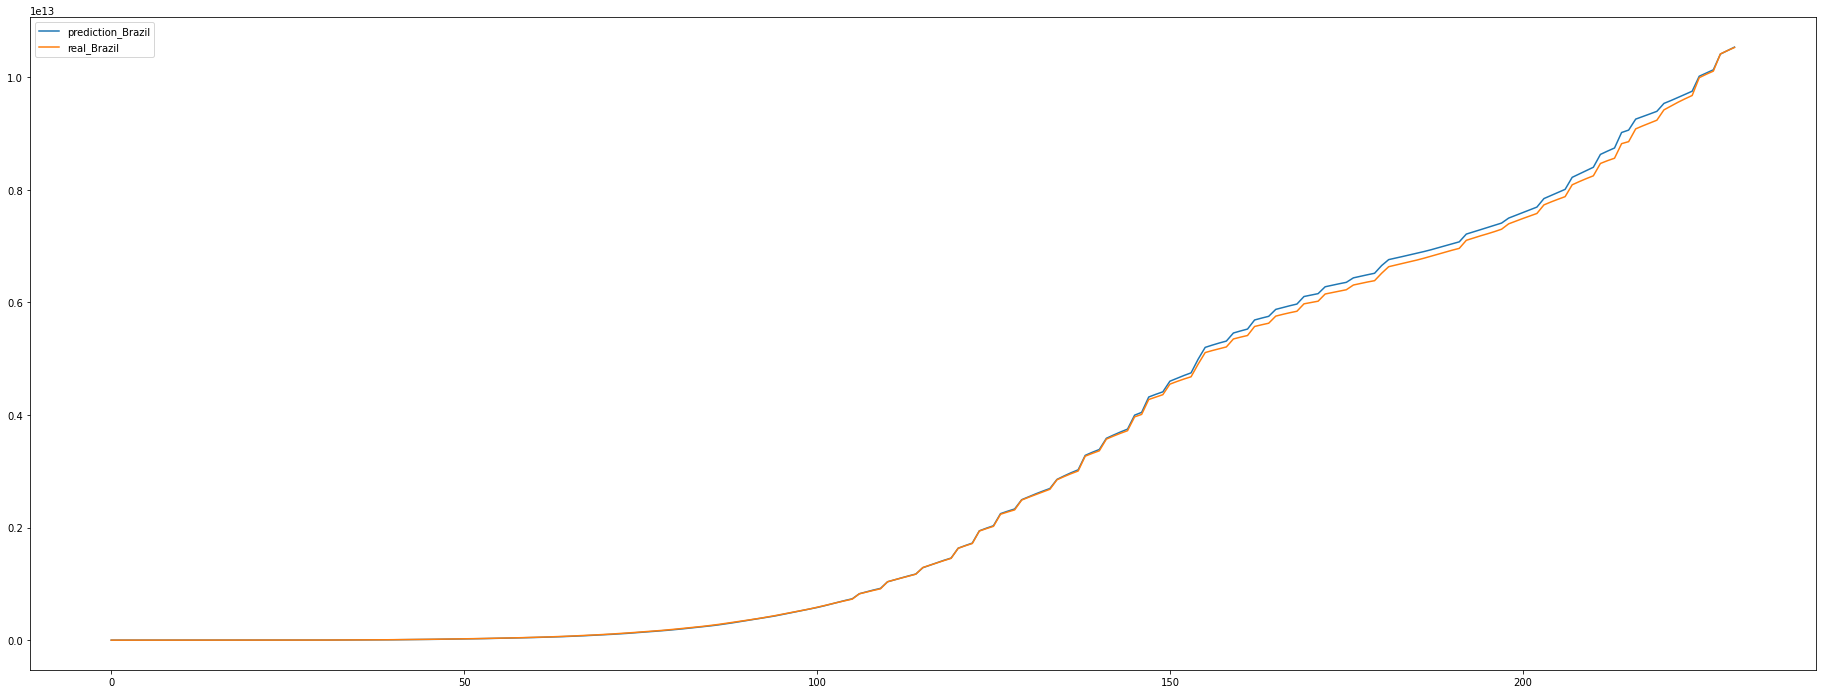

In [ ]:
test(["Brazil"], True)

Brazil 0.87358143351061
Thailand 0.9973395463489795
Malaysia 0.6518270239567896
Japan 1.6565475063488933
Republic of Korea 1.198650807903386


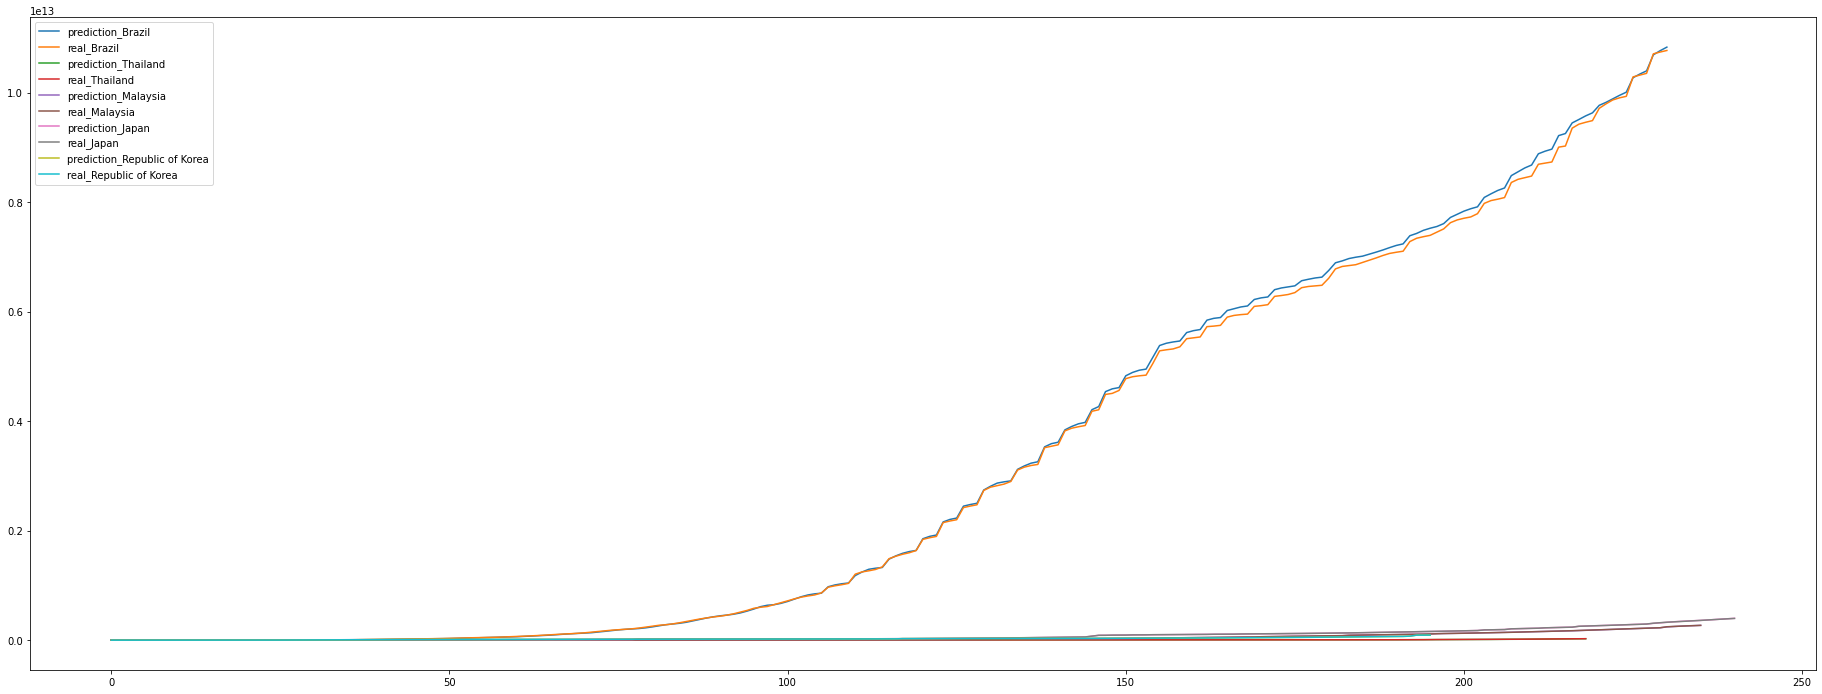

In [ ]:
def testNonMovingAvg(countryList, plot = False):
  for country in countryList:
    Xr = []
    Yr = []
    v = df[df["Country"] == country][NormalizedCumulativeCases].values
    for i in range(0, len(v) - IntervalDays - PredictionTargetDay):
      if isUptrend(country, i):
        Xr.append(v[i:i+IntervalDays])
        Yr.append(v[i+IntervalDays+PredictionTargetDay])
    Xr = np.array(Xr).reshape(-1, IntervalDays, 1)
    Yr = np.array(Yr)
    Yp = model.predict(Xr)
    Yr = cumulativeScaler.inverse_transform(Yr)
    Yp = cumulativeScaler.inverse_transform(Yp)
    print(country, mean_absolute_percentage_error(Yr, Yp))
    if plot:
      plt.plot(cumulativeScaler.inverse_transform(Yp), label='prediction_'+country)
      plt.plot(cumulativeScaler.inverse_transform(Yr), label='real_'+country)
      plt.legend()

testNonMovingAvg(test_country, True)